[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SeoulTechPSE/EngNm/blob/master/ch09_animation/ch09_double_pendulum_animation_solution.ipynb)

In [1]:
# Rendering sympy equations requires MathJax to be available within each cell output. 
# The following is a function that will make this happen for Colab.

if 'google.colab' in str(get_ipython()):
    
    from sympy import init_printing
    from sympy.printing import latex

    def colab_LaTeX_printer(exp, **options):  
        from google.colab.output._publish import javascript 

        url_ = "https://colab.research.google.com/static/mathjax/MathJax.js?"
        cfg_ = "config=TeX-MML-AM_HTMLorMML" # "config=default"

        javascript(url=url_+cfg_)

        return latex(exp, **options)

    init_printing(use_latex="mathjax", latex_printer=colab_LaTeX_printer) 

## Double Pendulum

Consider the rather complicated system of two coupled second-order and nonlinear ODEs for a double
pendulum

$~$

<center><img src="../figs/dimg270.gif" width="200"></center> 

$$
(m_1+m_2) l_1\ddot{\theta_1} + m_2l_2\ddot{\theta_2}\cos(\theta_1-\theta_2)
+ m_2l_2\left(\dot{\theta_2}\right)^2\sin(\theta_1-\theta_2)+g(m_1+m_2)\sin(\theta_1) = 0
$$

$$
m_2l_2\ddot{\theta_2} + m_2l_1\ddot{\theta_1}\cos(\theta_1-\theta_2) - m_2l_1 \left(\dot{\theta_1}\right)^2 \sin(\theta_1-\theta_2)
+m_2g\sin(\theta_2) = 0
$$

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from scipy import integrate
import sympy
sympy.init_printing()

1. We first have to write the system of two second-order ODEs as a system of four first-order ODEs on standard form. To this end, we need to introduce new functions $\text{ }y_1(t) = \theta_1(t)$, $\text{ }y_2(t) = \dot{\theta_1}(t)$, $\text{ }y_3(t) = \theta_2(t)$, $\text{ }y_4(t) = \dot{\theta_2}(t)$, $\text{ }$and rewrite the ODEs in terms of these functions.

In [3]:
t, g, m1, l1, m2, l2 = sympy.symbols("t, g, m_1, l_1, m_2, l_2")
theta1, theta2 = sympy.symbols("theta_1, theta_2", cls=sympy.Function)

ode1 = sympy.Eq((m1 +m2) *l1 *theta1(t).diff(t, t) +
                m2 *l2 *theta2(t).diff(t, t) *sympy.cos(theta1(t) -theta2(t)) +
                m2 *l2 *theta2(t).diff(t)**2 *sympy.sin(theta1(t) -theta2(t)) + 
                g *(m1 +m2) *sympy.sin(theta1(t)), 0)

ode2 = sympy.Eq(m2 *l2 *theta2(t).diff(t, t) +
                m2 *l1 *theta1(t).diff(t, t) *sympy.cos(theta1(t) -theta2(t)) -
                m2 *l1 *theta1(t).diff(t)**2 *sympy.sin(theta1(t) -theta2(t)) +
                m2 *g *sympy.sin(theta2(t)), 0)

In [4]:
y1, y2, y3, y4 = sympy.symbols("y_1, y_2, y_3, y_4", cls=sympy.Function)

varchange = {theta1(t).diff(t, t): y2(t).diff(t), 
             theta1(t): y1(t),
             theta2(t).diff(t, t): y4(t).diff(t), 
             theta2(t): y3(t)}

ode1_vc = ode1.subs(varchange)
ode2_vc = ode2.subs(varchange)
ode3 = y1(t).diff(t) - y2(t)
ode4 = y3(t).diff(t) - y4(t)

2. At this point, we have four coupled first-order ODEs for the functions $y_1$ to $y_4$. It only remains to solve for the derivatives of these functions to obtain the ODEs in standard form

In [5]:
y = sympy.Matrix([y1(t), y2(t), y3(t), y4(t)])
vcsol = sympy.solve((ode1_vc, ode2_vc, ode3, ode4), y.diff(t), dict=True)

f = y.diff(t).subs(vcsol[0]); f

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   g⋅m₂⋅sin(y₁(t) - 2⋅y₃(t)) 
⎢                                 g⋅m₁⋅sin(y₁(t)) + ───────────────────────── 
⎢                                                               2             
⎢                                 ────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [6]:
jac = sympy.Matrix([[fj.diff(yi) for yi in y] for fj in f]); jac

⎡                                                                             
⎢                                                                             
⎢                                                        ⎛                    
⎢                                                        ⎜                  g⋅
⎢                                                   2⋅m₂⋅⎜g⋅m₁⋅sin(y₁(t)) + ──
⎢                                                        ⎝                    
⎢                                                   ──────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [7]:
params = {m1: 5.0, l1: 2.0, m2: 1.0, l2: 1.0, g: 9.8}

f_np = sympy.lambdify((t, y), f.subs(params), 'numpy')
jac_np = sympy.lambdify((t, y), jac.subs(params), 'numpy')

In [8]:
y0 = [2.0, 0.0, 0.0, 0.0]

t = np.linspace(0, 20, 1000)
r = integrate.ode(f_np, jac_np).set_initial_value(y0, t[0])

In [9]:
dt = t[1] -t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t +dt)
    idx += 1

3. When visualizing this solution, it is more intuitive to animate the positions of the pendulums in the $x–y$ plane rather than their angular deflections

In [10]:
theta1_np, theta2_np = y[:, 0], y[:, 2]

x1 =  params[l1] *np.sin(theta1_np)
y1 = -params[l1] *np.cos(theta1_np)
x2 = x1 +params[l2] *np.sin(theta2_np)
y2 = y1 -params[l2] *np.cos(theta2_np)

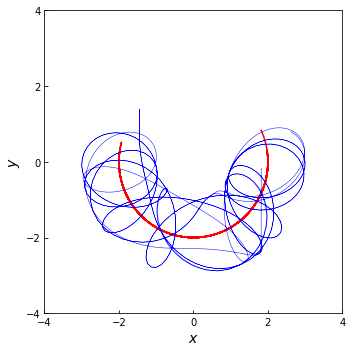

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x1, y1, 'r')
ax.plot(x2, y2, 'b', lw=0.5)
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
ax.set_xticks([-4,-2, 0, 2, 4])
ax.set_yticks([-4,-2, 0, 2, 4])
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.tick_params(which='both', direction='in')

fig.tight_layout()

**Construct the animation showing the complex oscillation of a double pendulum**

In [12]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')

fig, ax = plt.subplots(figsize=(5, 5))

ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
ax.set_xticks([-4,-2, 0, 2, 4])
ax.set_yticks([-4,-2, 0, 2, 4])
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.tick_params(which='both', direction='in')

plt.close()

In [13]:
line1, = ax.plot([], [], 'o-', color='r', lw=2)
line2, = ax.plot([], [], 'o-', color='b', lw=2)

time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line1.set_data([], [])
    line2.set_data([], [])    
    time_text.set_text('')
    
    return line1, line2, time_text


def animate(i):
    t_x1 = [0, x1[i]]
    t_y1 = [0, y1[i]]
    t_x2 = [x1[i], x2[i]]
    t_y2 = [y1[i], y2[i]]    

    line1.set_data(t_x1, t_y1)
    line2.set_data(t_x2, t_y2)    
    time_text.set_text(time_template % (i*dt))
    
    return line1, line2, time_text


ani = animation.FuncAnimation(fig, animate, range(1, len(y)),
                              interval=dt*1000, blit=True, init_func=init)
ani